In [39]:
!pip install lime

In [40]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
import lime
import lime.lime_tabular
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.inspection import PartialDependenceDisplay, permutation_importance

In [41]:
df = pd.read_csv('Phishing Websites Engineered.csv')

X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Model Training

In [42]:
base_estimators = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42))
]
stacking_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(random_state=42),
)
stacking_model.fit(X_train, y_train)

StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(random_state=42))],
                   final_estimator=LogisticRegression(random_state=42))

In [43]:
y_pred = stacking_model.predict(X_test)

In [44]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

print("Stacking Classifier Results (All Features):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Stacking Classifier Results (All Features):
Accuracy: 0.9393
Precision: 0.9412
Recall: 0.9329
F1 Score: 0.9370


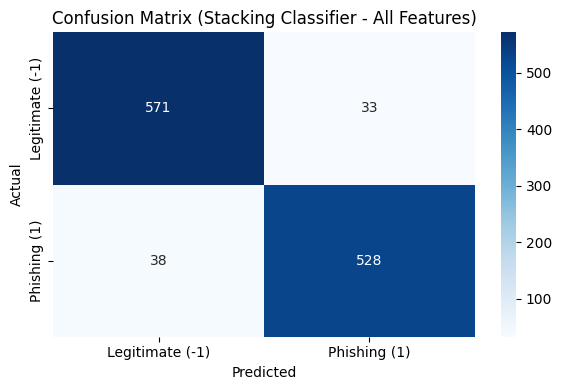

In [45]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Legitimate (-1)', 'Phishing (1)'],
           yticklabels=['Legitimate (-1)', 'Phishing (1)'])
plt.title('Confusion Matrix (Stacking Classifier - All Features)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Interpretability Technique

## SHAP

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/u

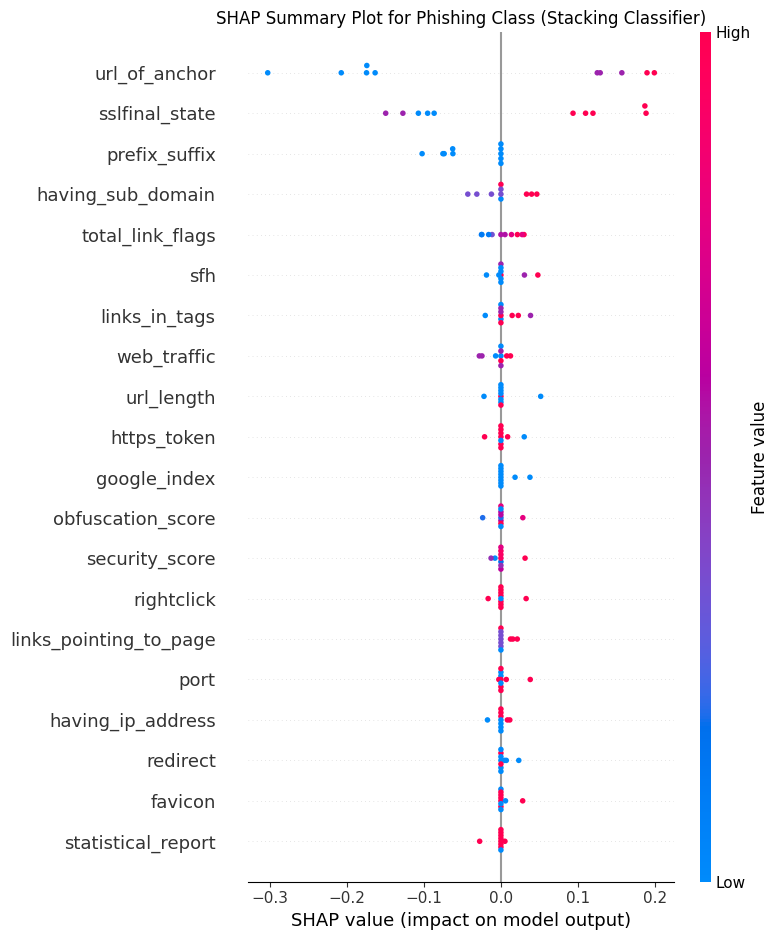

In [46]:
background = shap.sample(X_train, 100, random_state=42)
sample = X_test.sample(10, random_state=42)


def predict_proba_class(X):
    return stacking_model.predict_proba(X)[:, 1]

stacking_explainer = shap.KernelExplainer(predict_proba_class, background.values)

stacking_shap_values = stacking_explainer.shap_values(sample.values, nsamples=100)

shap.summary_plot(stacking_shap_values, sample, feature_names=sample.columns, show=False)
plt.title("SHAP Summary Plot for Phishing Class (Stacking Classifier)")
plt.tight_layout()
plt.show()

## LIME

In [47]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns.tolist(),
    class_names=['Legitimate', 'Phishing'],
    mode='classification'
)



In [48]:
def explain_instance_lime(model, model_name):
    i = np.random.randint(0, X_test.shape[0])
    exp = lime_explainer.explain_instance(
        X_test.iloc[i],
        model.predict_proba,
        num_features=10
    )
    print(f"LIME Explanation for model: {model_name} on instance {i}")
    exp.show_in_notebook(show_table=True)
    return exp

explain_instance_lime(stacking_model, "Stacking Classifier")

/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

LIME Explanation for model: Stacking Classifier on instance 569


# PFI

Top 5 Important Features (Permutation Importance):
              Feature  Importance
13     url_of_anchor    0.112479
7     sslfinal_state    0.093162
5      prefix_suffix    0.058803
25       web_traffic    0.008376
30  total_link_flags    0.004786


<Figure size 1000x600 with 0 Axes>

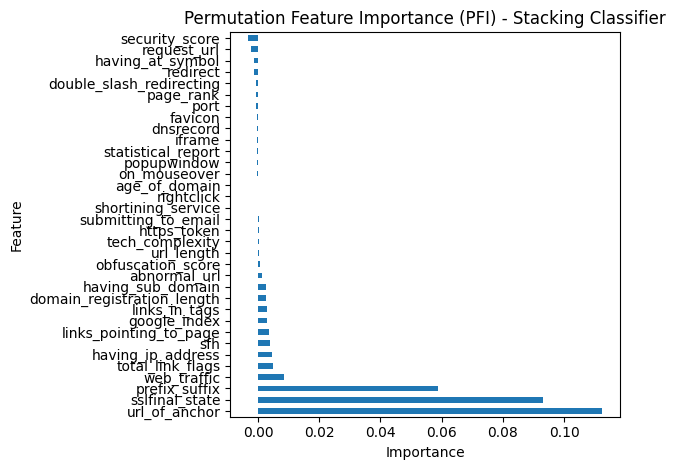

In [49]:
## Feature Importance via Permutation Importance
pfi_result = permutation_importance(stacking_model, X_test, y_test, n_repeats=10, random_state=42)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': pfi_result.importances_mean
}).sort_values('Importance', ascending=False)

print("Top 5 Important Features (Permutation Importance):\n", feature_importance.head())

# Plot PFI
plt.figure(figsize=(10, 6))
pfi_df.plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.title("Permutation Feature Importance (PFI) - Stacking Classifier")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# PDP & ICE

Feature url_of_anchor has 3 unique values: [ 0 -1  1]
Feature sslfinal_state has 3 unique values: [-1  1  0]
Feature prefix_suffix has 2 unique values: [-1  1]
Feature web_traffic has 3 unique values: [ 1  0 -1]
Feature total_link_flags has 9 unique values: [ 1 -2  0  2 -1  4  3 -3 -4]


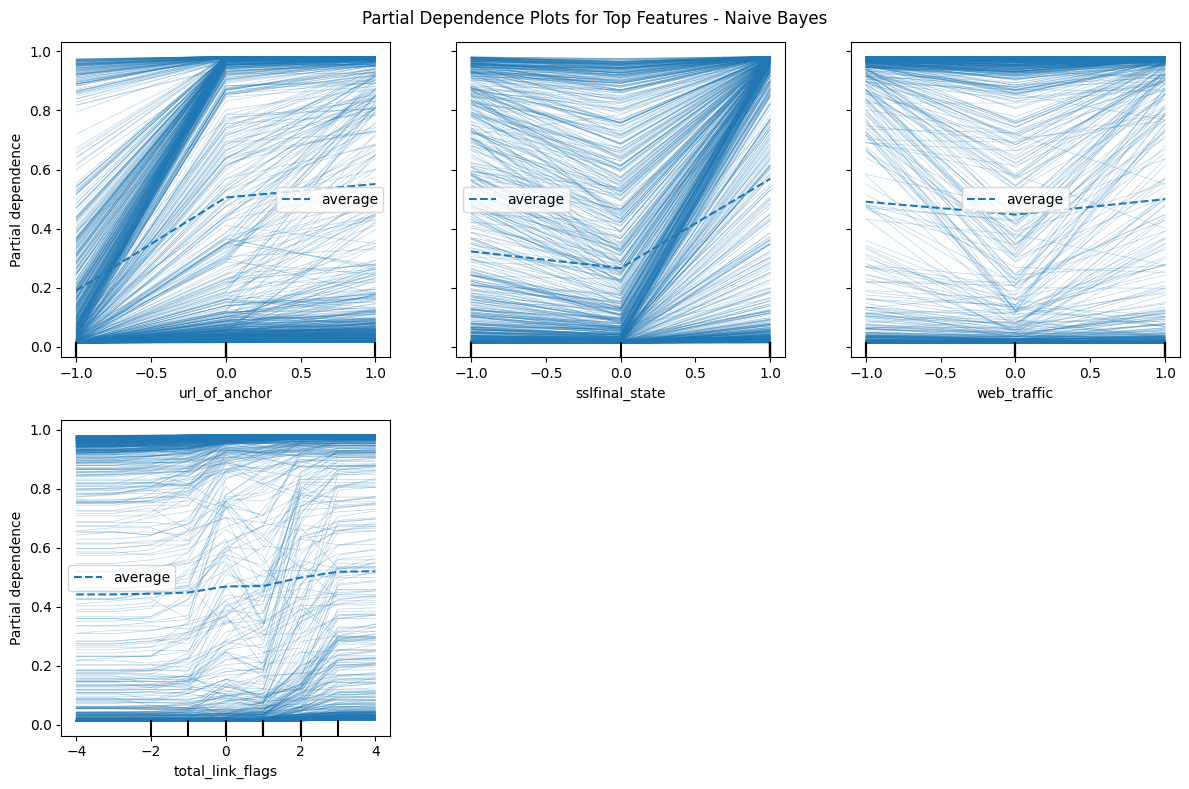

In [50]:
top_features = feature_importance['Feature'].head(5).tolist()
suitable_features = []
for feature in top_features:
    unique_values = X_test[feature].nunique()
    print(f"Feature {feature} has {unique_values} unique values: {X_test[feature].unique()}")
    if unique_values > 2:
        suitable_features.append(feature)

fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    stacking_model,
    X_test,
    features=suitable_features,
    grid_resolution=10,
    kind ="both",
    ax=ax
)
plt.suptitle("Partial Dependence Plots for Top Features - Naive Bayes")
plt.tight_layout()
plt.show()